In [184]:
# import python libraries
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import matplotlib.patheffects as PathEffects

In [185]:
# load daily close price data
df = pd.read_csv('../bitcoin-data/bitcoin-daily-data.csv')
orig_dates = df['date'].to_list()
orig_prices = df['price'].to_list()
df.tail(5)

date     price
4756  1/11/22  42666.00
4757  1/12/22  44370.22
4758  1/13/22  43040.81
4759  1/14/22  43012.89
4760  1/15/22  42763.84

In [341]:
# create/load sb-dca-analysis_data.csv
if not os.path.exists('sb-dca-analysis_data.csv'):
    sb_strategy_df = pd.DataFrame(columns=[['start_date', 'start_date_ind', 'num_days',
                                            'sb_percentage', 'dollars_invested', 'dca_interval',
                                            'sats_stacked', 'final_usd_value',
                                            'final_usd_return']])
else:
    sb_strategy_df = pd.read_csv('sb-dca-analysis_data.csv')
    print(len(sb_strategy_df))
sb_strategy_df.head(5)

1442987


start_date  start_date_ind  num_days  sb_percentage  dollars_invested  \
0     1/1/16            2554       365              0             10000   
1     1/1/16            2554       365              1             10000   
2     1/1/16            2554       365              2             10000   
3     1/1/16            2554       365              3             10000   
4     1/1/16            2554       365              4             10000   

   dca_interval  sats_stacked  final_usd_value  final_usd_return  
0             1  1.868537e+09         18091.69           80.9169  
1             1  1.872868e+09         18133.63           81.3363  
2             1  1.877200e+09         18175.57           81.7557  
3             1  1.881531e+09         18217.50           82.1750  
4             1  1.885863e+09         18259.44           82.5944

In [187]:
def sb_dca_analysis(start_ind, num_days, dollars_invested, dca_interval, sb_percentage):
    end_ind = start_ind + num_days
    initial_sb_usd = dollars_invested * sb_percentage / 100
    cash_stack = dollars_invested - initial_sb_usd
    intervals = np.floor(num_days/dca_interval)
    interval_investment = cash_stack/intervals
    sat_stack = initial_sb_usd / df['price'].iloc[start_ind] * 100000000
    for i in range(end_ind - start_ind):
        bitcoin_price = df['price'].iloc[start_ind+i+1]
        if i%dca_interval == 0:
            sat_stack += int(interval_investment/bitcoin_price*100000000)
            cash_stack -= interval_investment
    return sat_stack, float('%.2f' % (sat_stack*bitcoin_price/100000000+cash_stack))

In [340]:
# find index of date
# df['date'].to_list().index('1/15/18')

In [210]:
# run function
# df['date'].to_list().index('1/1/10')
# 1/1/11 [728], 1/1/14 [1824], 1/1/15 [2189], 1/1/16 [2554], 1/1/17 [2920], 1/1/18 [3285],
# 1/1/19 [3650], 1/1/20 [4015], 1/1/21 [4381], 1/1/22 [4746]
num_days_list = [730] # 365, 730, 1096, 1461
start_date = 4014 # 4380, 4014, 3649, 3284
end_dates = [4029] # 4381, 4029, 3664, 3299
# num_days_list = [365, 730, 1096, 1461]
# start_date = 1824
# end_dates = [4381, 4015, 3650, 3285]
dca_intervals = [1]
dollars_invested = 10000
sb_percentages = range(101)
for n in range(len(num_days_list)):
    num_days = num_days_list[n]
    start_inds = [i+start_date for i in range(end_dates[n]-start_date)]
    for start_ind in start_inds:
        if start_ind%100 == 0:
            print(start_ind)
        for dca_interval in dca_intervals:
            for sb_percentage in sb_percentages:
                if len(sb_strategy_df) == 0:
                    results = sb_dca_analysis(start_ind, num_days, dollars_invested,
                                              dca_interval, sb_percentage)
                    sb_strategy_df = pd.DataFrame({
                        'start_date': [df['date'].iloc[start_ind]],
                        'start_date_ind': [start_ind],
                        'num_days': [num_days],
                        'sb_percentage': [sb_percentage],
                        'dollars_invested': [dollars_invested],
                        'dca_interval': [dca_interval],
                        'sats_stacked': [results[0]],
                        'final_usd_value': [results[1]],
                        'final_usd_return': ((results[1]-dollars_invested)/
                                          (dollars_invested*100))
                    })
                elif len(sb_strategy_df[
                    (sb_strategy_df['start_date'] == df['date'].iloc[start_ind]) &
                    (sb_strategy_df['start_date_ind'] == start_ind) &
                    (sb_strategy_df['num_days'] == num_days) &
                    (sb_strategy_df['sb_percentage'] == sb_percentage) &
                    (sb_strategy_df['dollars_invested'] == dollars_invested) &
                    (sb_strategy_df['dca_interval'] == dca_interval)]) == 0:
                    
                    results = sb_dca_analysis(start_ind,
                                              num_days,
                                              dollars_invested,
                                              dca_interval,
                                              sb_percentage)
                    temp_df = pd.DataFrame({
                        'start_date': [df['date'].iloc[start_ind]],
                        'start_date_ind': [start_ind],
                        'num_days': [num_days],
                        'sb_percentage': [sb_percentage],
                        'dollars_invested': [dollars_invested],
                        'dca_interval': [dca_interval],
                        'sats_stacked': [results[0]],
                        'final_usd_value': [results[1]],
                        'final_usd_return': (results[1]-dollars_invested)/dollars_invested*100
                    })
                    sb_strategy_df = sb_strategy_df.append(temp_df, ignore_index=True)

sb_strategy_df.to_csv('sb-dca-analysis_data.csv', index=False)

In [183]:
# sb_strategy_df.to_csv('sb-dca-analysis_data.csv', index=False)

In [274]:
print('4-Year Analysis Results')
num_days = 1461
temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == 1) &
                         (sb_strategy_df['num_days'] == num_days) &
                         (sb_strategy_df['sb_percentage'] == 100)]
print('%i 4-Year Ranges' % len(temp_df))
print('%s [%i] - %s [%i]' % (df['date'].iloc[temp_df['start_date_ind'].min()],
                             temp_df['start_date_ind'].min(),
                             df['date'].iloc[temp_df['start_date_ind'].max()+1],
                             temp_df['start_date_ind'].max()+1))

temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == 1) &
                         (sb_strategy_df['num_days'] == num_days)]
sb_win, dca_win = 0, 0
for sd in temp_df['start_date_ind'].unique():
    sb_gain = temp_df['final_usd_return'][(temp_df['start_date_ind'] == sd) &
                                   (temp_df['sb_percentage'] == 100)].iloc[0]
    dca_gain = temp_df['final_usd_return'][(temp_df['start_date_ind'] == sd) &
                                    (temp_df['sb_percentage'] == 0)].iloc[0]
    if sb_gain > dca_gain:
        sb_win += 1
    else:
        dca_win += 1
print('Smash Buy: %i/%i (%s%%)' % (sb_win, sb_win+dca_win,
                                   format(sb_win/(sb_win+dca_win)*100, '.1f')))
print('DCA: %i/%i (%s%%)' % (dca_win, sb_win+dca_win, format(dca_win/(sb_win+dca_win)*100, '.1f')))


4-Year Analysis Results
3024 4-Year Ranges
10/5/09 [275] - 1/15/18 [3299]
Smash Buy: 2732/3024 (90.3%)
DCA: 292/3024 (9.7%)


Median Returns
0% SB, 100% DCA: 914.61%
50% SB, 50% DCA: 2,030.70%
100% SB, 0% DCA: 3,073.60%


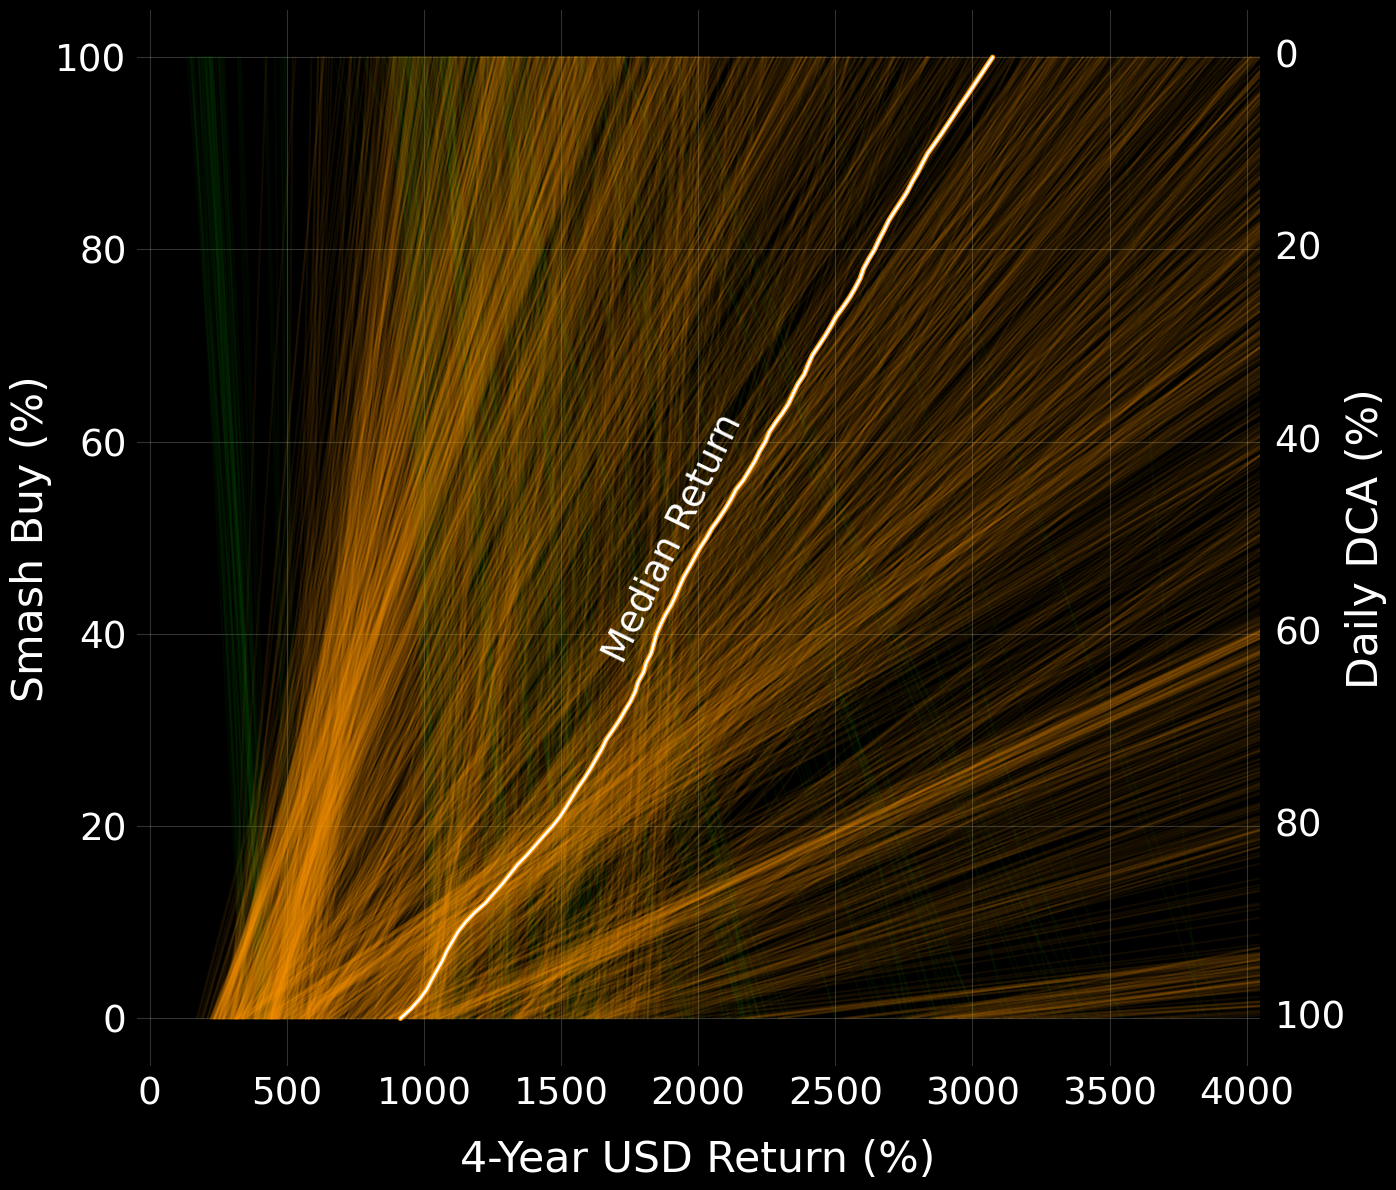

In [307]:
# 4-year time period figure

res = (1400, 1200)
size = res[0]/96.
size_y = res[1]/96.
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
ax.set_facecolor('black')
plot_start_date_ind = 275
plot_end_date_ind = 3299
plot_dca_interval = 1
plot_num_days = 1461
ymin, ymax = -5, 105
xmin, xmax = -50, 4050
plot_sb_percentages = range(101)
for d in range(plot_end_date_ind-plot_start_date_ind):
    temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
                             (sb_strategy_df['num_days'] == plot_num_days) &
                             (sb_strategy_df['start_date_ind'] == plot_start_date_ind+d)]
    try:
        sb_return = temp_df[temp_df['sb_percentage'] == 100]['final_usd_return'].iloc[0]
        dca_return = temp_df[temp_df['sb_percentage'] == 0]['final_usd_return'].iloc[0]
        if sb_return > dca_return:
            plt.plot(temp_df['final_usd_return'], temp_df['sb_percentage'], color='#ff9900',
                     alpha=0.065, zorder=4)
        else:
            plt.plot(temp_df['final_usd_return'], temp_df['sb_percentage'], color='green',
                     alpha=0.065, zorder=3)
    except:
        pass
sb_medians = []
print('Median Returns')
for plot_sb_percentage in plot_sb_percentages:
    temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
                             (sb_strategy_df['num_days'] == plot_num_days) &
                             (sb_strategy_df['start_date_ind'] >= plot_start_date_ind) &
                             (sb_strategy_df['sb_percentage'] == plot_sb_percentage)]
    sb_min = temp_df['final_usd_return'].min()
    sb_max = temp_df['final_usd_return'].max()
    sb_mean = temp_df['final_usd_return'].mean()
    sb_median = temp_df['final_usd_return'].median()
    if plot_sb_percentage == 0:
        print('0%% SB, 100%% DCA: %s%%' % format(sb_median, ',.2f'))
    elif plot_sb_percentage == 50:
        print('50%% SB, 50%% DCA: %s%%' % format(sb_median, ',.2f'))
        plt.text(sb_median-(xmax-xmin)*0.03, plot_sb_percentage, 'Median Return', rotation=64.,
                 fontsize=28, color='w', horizontalalignment='center', verticalalignment='center',
                 zorder=6)
    elif plot_sb_percentage == 100:
        print('100%% SB, 0%% DCA: %s%%' % format(sb_median, ',.2f'))
    sb_std = temp_df['final_usd_return'].std()
    sb_medians.append(sb_median)
plt.plot(sb_medians, plot_sb_percentages, color='#ff9900', lw=4, solid_capstyle='round', zorder=5)
plt.plot(sb_medians, plot_sb_percentages, color='w', lw=2, solid_capstyle='round', zorder=5)
ax.grid(True, color='w', alpha=0.2)
ax.set_ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.yticks(color='w', fontsize=28)
plt.xticks(color='w', fontsize=28)
plt.text(xmax + (xmax - xmin)*0.0125, 0, '100', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 20, '80', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 40, '60', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 60, '40', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 80, '20', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 100, '0', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmin - (xmax - xmin)*0.075, 50, 'Smash Buy (%)', color='w', fontsize=32,
         horizontalalignment='right', verticalalignment='center', rotation=90)
plt.text(xmax + (xmax - xmin)*0.075, 50, 'Daily DCA (%)', color='w', fontsize=32,
         horizontalalignment='left', verticalalignment='center', rotation=90)
ax.set_xlabel('4-Year USD Return (%)', labelpad=20, color='w', fontsize=32)
plt.tight_layout()
plt.show()

In [309]:
## print('3-Year Analysis Results')
num_days = 1096
temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == 1) &
                         (sb_strategy_df['num_days'] == num_days) &
                         (sb_strategy_df['sb_percentage'] == 100)]
print('%i 3-Year Ranges' % len(temp_df))
print('%s [%i] - %s [%i]' % (df['date'].iloc[temp_df['start_date_ind'].min()],
                             temp_df['start_date_ind'].min(),
                             df['date'].iloc[temp_df['start_date_ind'].max()+1],
                             temp_df['start_date_ind'].max()+1))

temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == 1) &
                         (sb_strategy_df['num_days'] == num_days)]
sb_win, dca_win = 0, 0
for sd in temp_df['start_date_ind'].unique():
    sb_gain = temp_df['final_usd_return'][(temp_df['start_date_ind'] == sd) &
                                   (temp_df['sb_percentage'] == 100)].iloc[0]
    dca_gain = temp_df['final_usd_return'][(temp_df['start_date_ind'] == sd) &
                                    (temp_df['sb_percentage'] == 0)].iloc[0]
    if sb_gain > dca_gain:
        sb_win += 1
    else:
        dca_win += 1
print('Smash Buy: %i/%i (%s%%)' % (sb_win, sb_win+dca_win,
                                   format(sb_win/(sb_win+dca_win)*100, '.1f')))
print('DCA: %i/%i (%s%%)' % (dca_win, sb_win+dca_win, format(dca_win/(sb_win+dca_win)*100, '.1f')))


3389 3-Year Ranges
10/5/09 [275] - 1/15/19 [3664]
Smash Buy: 2844/3389 (83.9%)
DCA: 545/3389 (16.1%)


Median Returns
0% SB, 100% DCA: 468.21%
50% SB, 50% DCA: 971.45%
100% SB, 0% DCA: 1,543.70%


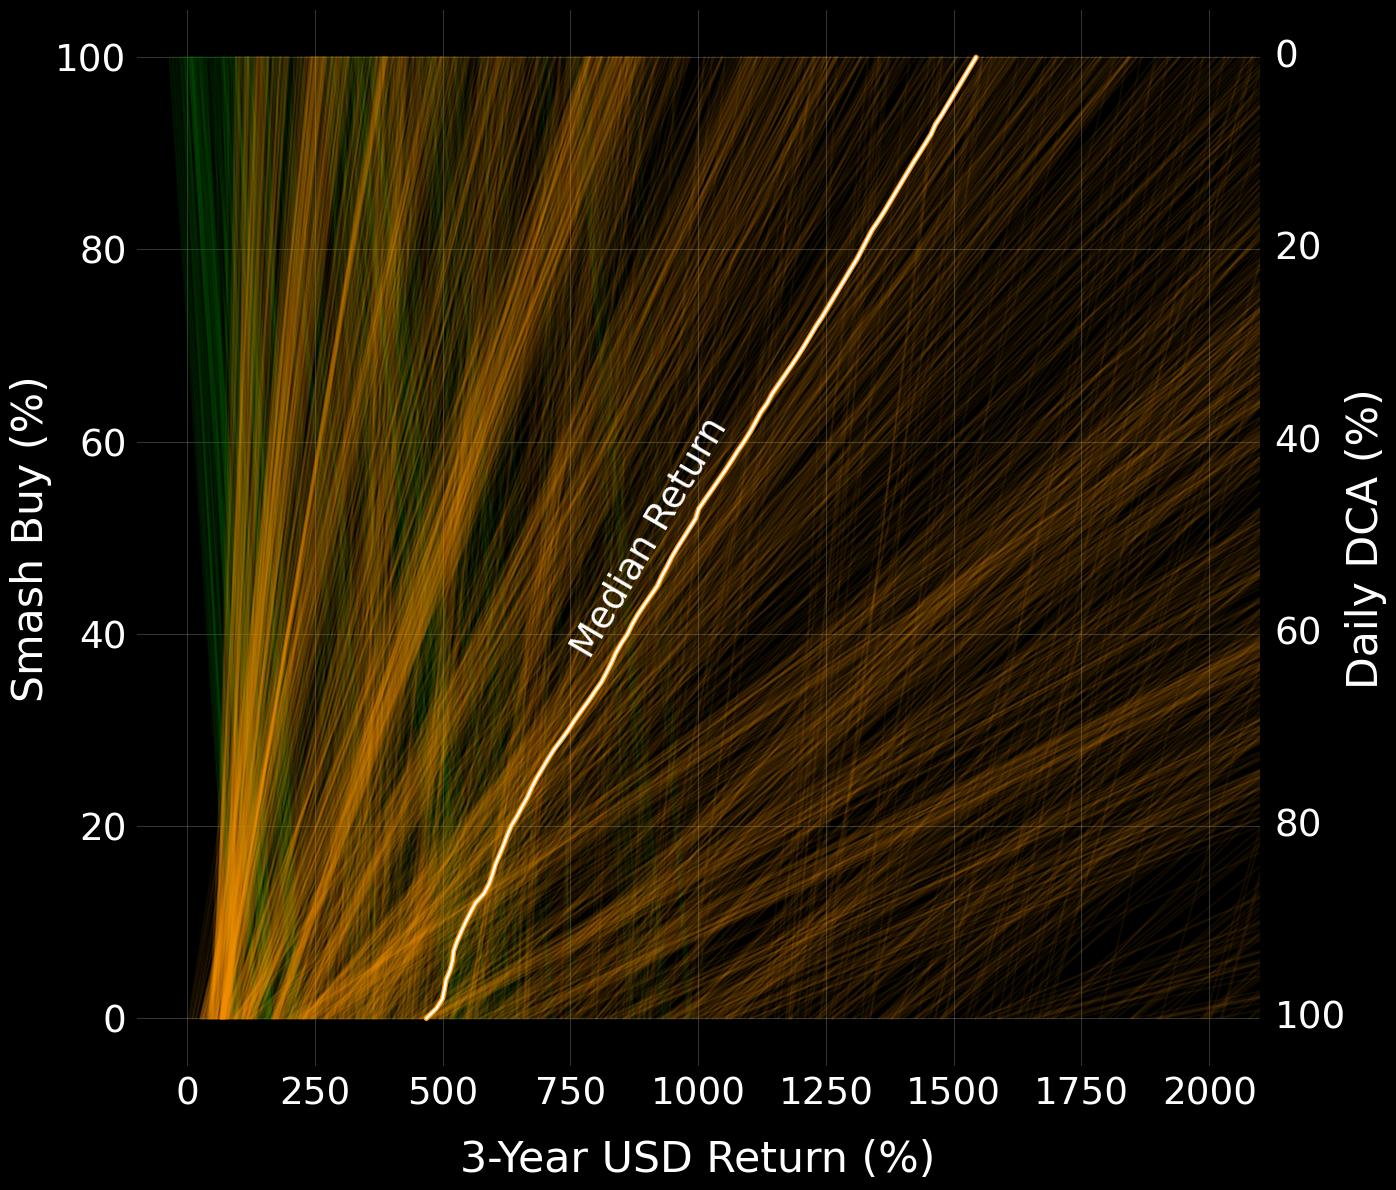

In [314]:
# 3-year time period figure

res = (1400, 1200)
size = res[0]/96.
size_y = res[1]/96.
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
ax.set_facecolor('black')
plot_start_date_ind = 275
plot_end_date_ind = 3664
plot_dca_interval = 1
plot_num_days = 1096
ymin, ymax = -5, 105
xmin, xmax = -100, 2100
plot_sb_percentages = range(101)
for d in range(plot_end_date_ind-plot_start_date_ind):
    temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
                             (sb_strategy_df['num_days'] == plot_num_days) &
                             (sb_strategy_df['start_date_ind'] == plot_start_date_ind+d)]
    try:
        sb_return = temp_df[temp_df['sb_percentage'] == 100]['final_usd_return'].iloc[0]
        dca_return = temp_df[temp_df['sb_percentage'] == 0]['final_usd_return'].iloc[0]
        if sb_return > dca_return:
            plt.plot(temp_df['final_usd_return'], temp_df['sb_percentage'], color='#ff9900',
                     alpha=0.065, zorder=4)
        else:
            plt.plot(temp_df['final_usd_return'], temp_df['sb_percentage'], color='green',
                     alpha=0.065, zorder=3)
    except:
        pass
sb_medians = []
print('Median Returns')
for plot_sb_percentage in plot_sb_percentages:
    temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
                             (sb_strategy_df['num_days'] == plot_num_days) &
                             (sb_strategy_df['start_date_ind'] >= plot_start_date_ind) &
                             (sb_strategy_df['sb_percentage'] == plot_sb_percentage)]
    sb_min = temp_df['final_usd_return'].min()
    sb_max = temp_df['final_usd_return'].max()
    sb_mean = temp_df['final_usd_return'].mean()
    sb_median = temp_df['final_usd_return'].median()
    if plot_sb_percentage == 0:
        print('0%% SB, 100%% DCA: %s%%' % format(sb_median, ',.2f'))
    elif plot_sb_percentage == 50:
        print('50%% SB, 50%% DCA: %s%%' % format(sb_median, ',.2f'))
        plt.text(sb_median-(xmax-xmin)*0.03, plot_sb_percentage, 'Median Return', rotation=59.5,
                 fontsize=28, color='w', horizontalalignment='center', verticalalignment='center',
                 zorder=6)
    elif plot_sb_percentage == 100:
        print('100%% SB, 0%% DCA: %s%%' % format(sb_median, ',.2f'))
    sb_std = temp_df['final_usd_return'].std()
    sb_medians.append(sb_median)
plt.plot(sb_medians, plot_sb_percentages, color='#ff9900', lw=4, solid_capstyle='round', zorder=5)
plt.plot(sb_medians, plot_sb_percentages, color='w', lw=2, solid_capstyle='round', zorder=5)
ax.grid(True, color='w', alpha=0.2)
ax.set_ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.yticks(color='w', fontsize=28)
plt.xticks(color='w', fontsize=28)
plt.text(xmax + (xmax - xmin)*0.0125, 0, '100', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 20, '80', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 40, '60', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 60, '40', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 80, '20', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 100, '0', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmin - (xmax - xmin)*0.075, 50, 'Smash Buy (%)', color='w', fontsize=32,
         horizontalalignment='right', verticalalignment='center', rotation=90)
plt.text(xmax + (xmax - xmin)*0.075, 50, 'Daily DCA (%)', color='w', fontsize=32,
         horizontalalignment='left', verticalalignment='center', rotation=90)
ax.set_xlabel('3-Year USD Return (%)', labelpad=20, color='w', fontsize=32)
plt.tight_layout()
plt.show()

In [315]:
print('2-Year Analysis Results')
num_days = 730
temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == 1) &
                         (sb_strategy_df['num_days'] == num_days) &
                         (sb_strategy_df['sb_percentage'] == 100)]
print('%i 2-Year Ranges' % len(temp_df))
print('%s [%i] - %s [%i]' % (df['date'].iloc[temp_df['start_date_ind'].min()],
                             temp_df['start_date_ind'].min(),
                             df['date'].iloc[temp_df['start_date_ind'].max()+1],
                             temp_df['start_date_ind'].max()+1))

temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == 1) &
                         (sb_strategy_df['num_days'] == num_days)]
sb_win, dca_win = 0, 0
for sd in temp_df['start_date_ind'].unique():
    sb_gain = temp_df['final_usd_return'][(temp_df['start_date_ind'] == sd) &
                                   (temp_df['sb_percentage'] == 100)].iloc[0]
    dca_gain = temp_df['final_usd_return'][(temp_df['start_date_ind'] == sd) &
                                    (temp_df['sb_percentage'] == 0)].iloc[0]
    if sb_gain > dca_gain:
        sb_win += 1
    else:
        dca_win += 1
print('Smash Buy: %i/%i (%s%%)' % (sb_win, sb_win+dca_win,
                                   format(sb_win/(sb_win+dca_win)*100, '.1f')))
print('DCA: %i/%i (%s%%)' % (dca_win, sb_win+dca_win, format(dca_win/(sb_win+dca_win)*100, '.1f')))


2-Year Analysis Results
3754 2-Year Ranges
10/5/09 [275] - 1/15/20 [4029]
Smash Buy: 2987/3754 (79.6%)
DCA: 767/3754 (20.4%)


Median Returns
0% SB, 100% DCA: 259.12%
50% SB, 50% DCA: 513.05%
100% SB, 0% DCA: 661.02%


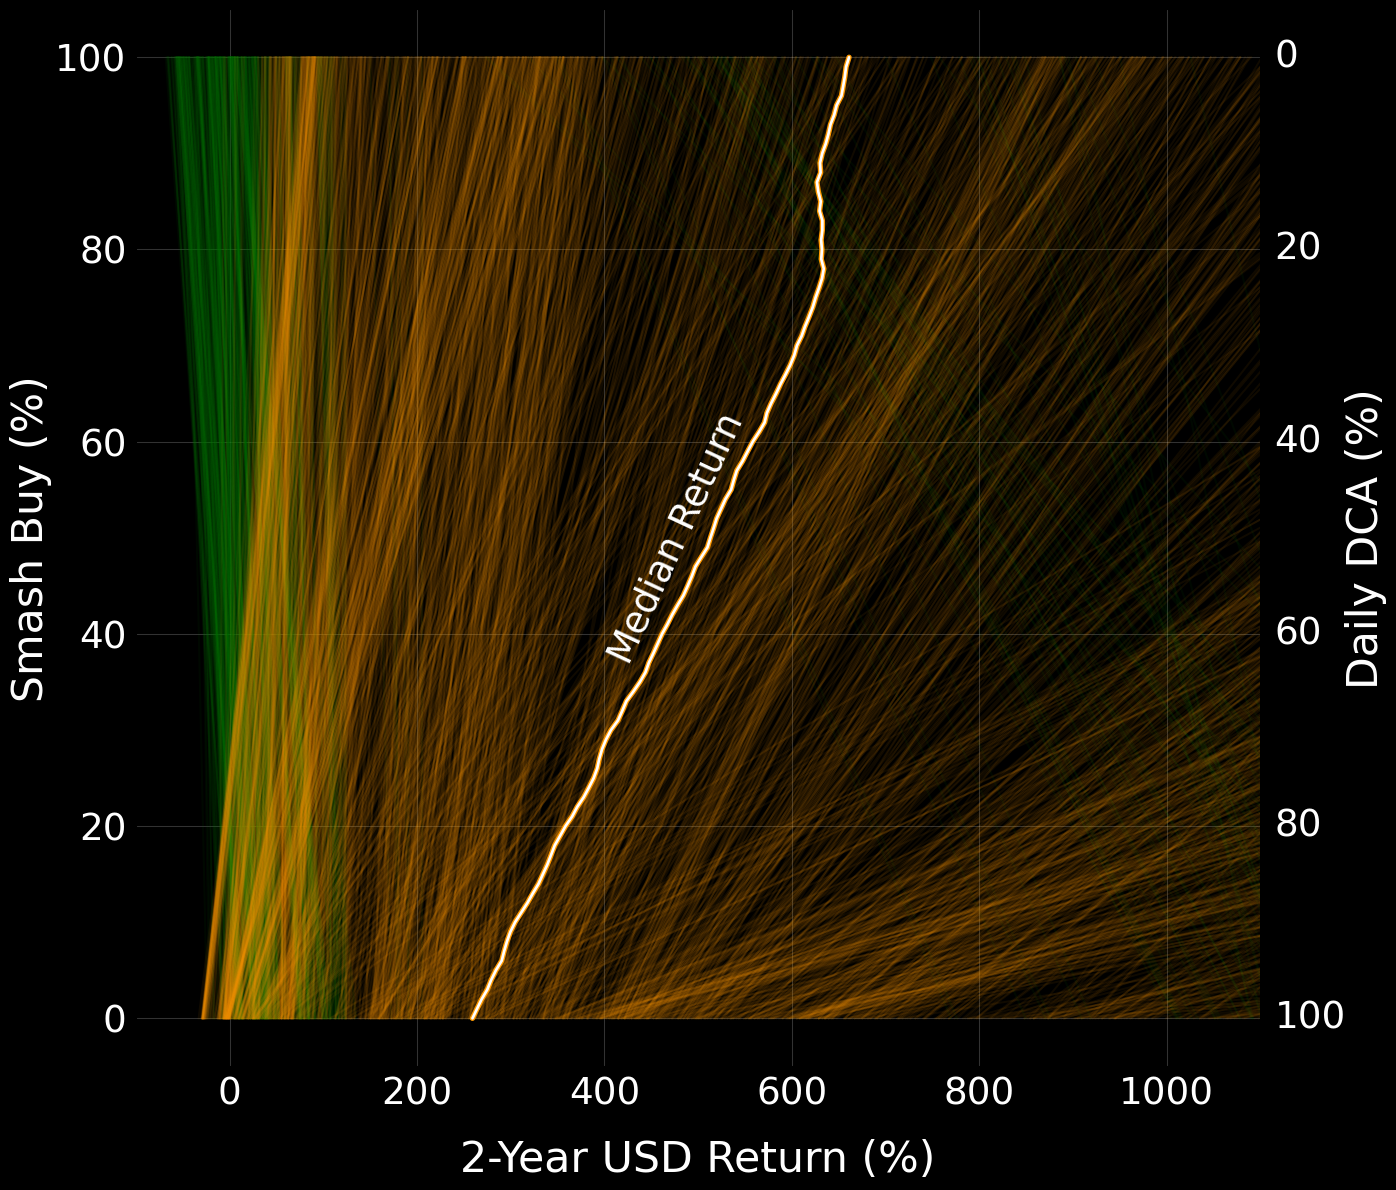

In [322]:
# 2-year time period figure

res = (1400, 1200)
size = res[0]/96.
size_y = res[1]/96.
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
ax.set_facecolor('black')
plot_start_date_ind = 275
plot_end_date_ind = 4029
plot_dca_interval = 1
plot_num_days = 730
ymin, ymax = -5, 105
xmin, xmax = -100, 1100
plot_sb_percentages = range(101)
for d in range(plot_end_date_ind-plot_start_date_ind):
    temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
                             (sb_strategy_df['num_days'] == plot_num_days) &
                             (sb_strategy_df['start_date_ind'] == plot_start_date_ind+d)]
    try:
        sb_return = temp_df[temp_df['sb_percentage'] == 100]['final_usd_return'].iloc[0]
        dca_return = temp_df[temp_df['sb_percentage'] == 0]['final_usd_return'].iloc[0]
        if sb_return > dca_return:
            plt.plot(temp_df['final_usd_return'], temp_df['sb_percentage'], color='#ff9900',
                     alpha=0.065, zorder=4)
        else:
            plt.plot(temp_df['final_usd_return'], temp_df['sb_percentage'], color='green',
                     alpha=0.065, zorder=3)
    except:
        pass
sb_medians = []
print('Median Returns')
for plot_sb_percentage in plot_sb_percentages:
    temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
                             (sb_strategy_df['num_days'] == plot_num_days) &
                             (sb_strategy_df['start_date_ind'] >= plot_start_date_ind) &
                             (sb_strategy_df['sb_percentage'] == plot_sb_percentage)]
    sb_min = temp_df['final_usd_return'].min()
    sb_max = temp_df['final_usd_return'].max()
    sb_mean = temp_df['final_usd_return'].mean()
    sb_median = temp_df['final_usd_return'].median()
    if plot_sb_percentage == 0:
        print('0%% SB, 100%% DCA: %s%%' % format(sb_median, ',.2f'))
    elif plot_sb_percentage == 50:
        print('50%% SB, 50%% DCA: %s%%' % format(sb_median, ',.2f'))
        plt.text(sb_median-(xmax-xmin)*0.03, plot_sb_percentage, 'Median Return', rotation=65.,
                 fontsize=28, color='w', horizontalalignment='center', verticalalignment='center',
                 zorder=6)
    elif plot_sb_percentage == 100:
        print('100%% SB, 0%% DCA: %s%%' % format(sb_median, ',.2f'))
    sb_std = temp_df['final_usd_return'].std()
    sb_medians.append(sb_median)
plt.plot(sb_medians, plot_sb_percentages, color='#ff9900', lw=4, solid_capstyle='round', zorder=5)
plt.plot(sb_medians, plot_sb_percentages, color='w', lw=2, solid_capstyle='round', zorder=5)
ax.grid(True, color='w', alpha=0.2)
ax.set_ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.yticks(color='w', fontsize=28)
plt.xticks(color='w', fontsize=28)
plt.text(xmax + (xmax - xmin)*0.0125, 0, '100', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 20, '80', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 40, '60', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 60, '40', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 80, '20', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 100, '0', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmin - (xmax - xmin)*0.075, 50, 'Smash Buy (%)', color='w', fontsize=32,
         horizontalalignment='right', verticalalignment='center', rotation=90)
plt.text(xmax + (xmax - xmin)*0.075, 50, 'Daily DCA (%)', color='w', fontsize=32,
         horizontalalignment='left', verticalalignment='center', rotation=90)
ax.set_xlabel('2-Year USD Return (%)', labelpad=20, color='w', fontsize=32)
plt.tight_layout()
plt.show()

In [323]:
print('1-Year Analysis Results')
num_days = 365
temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == 1) &
                         (sb_strategy_df['num_days'] == num_days) &
                         (sb_strategy_df['sb_percentage'] == 100)]
print('%i 1-Year Ranges' % len(temp_df))
print('%s [%i] - %s [%i]' % (df['date'].iloc[temp_df['start_date_ind'].min()],
                             temp_df['start_date_ind'].min(),
                             df['date'].iloc[temp_df['start_date_ind'].max()+1],
                             temp_df['start_date_ind'].max()+1))

temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == 1) &
                         (sb_strategy_df['num_days'] == num_days)]
sb_win, dca_win = 0, 0
for sd in temp_df['start_date_ind'].unique():
    sb_gain = temp_df['final_usd_return'][(temp_df['start_date_ind'] == sd) &
                                   (temp_df['sb_percentage'] == 100)].iloc[0]
    dca_gain = temp_df['final_usd_return'][(temp_df['start_date_ind'] == sd) &
                                    (temp_df['sb_percentage'] == 0)].iloc[0]
    if sb_gain > dca_gain:
        sb_win += 1
    else:
        dca_win += 1
print('Smash Buy: %i/%i (%s%%)' % (sb_win, sb_win+dca_win,
                                   format(sb_win/(sb_win+dca_win)*100, '.1f')))
print('DCA: %i/%i (%s%%)' % (dca_win, sb_win+dca_win, format(dca_win/(sb_win+dca_win)*100, '.1f')))


1-Year Analysis Results
4120 1-Year Ranges
10/5/09 [275] - 1/15/21 [4395]
Smash Buy: 3072/4120 (74.6%)
DCA: 1048/4120 (25.4%)


Median Returns
0% SB, 100% DCA: 79.24%
50% SB, 50% DCA: 132.15%
100% SB, 0% DCA: 188.55%


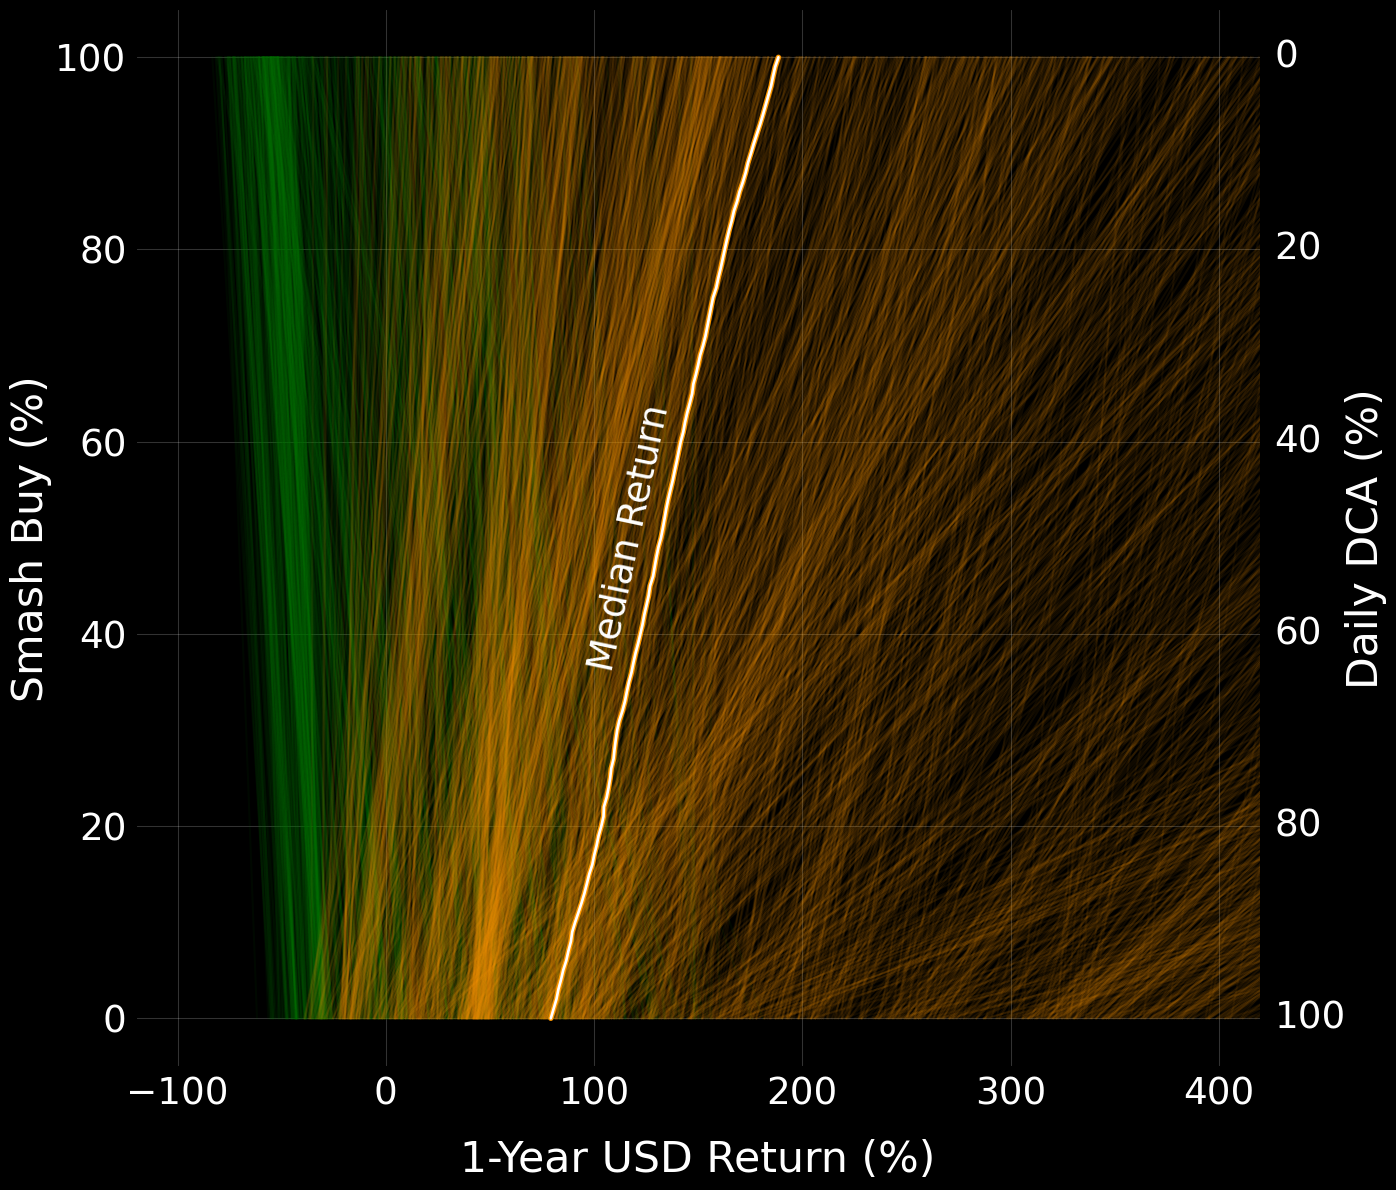

In [338]:
# 1-year time period figure

res = (1400, 1200)
size = res[0]/96.
size_y = res[1]/96.
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
ax.set_facecolor('black')
plot_start_date_ind = 275
plot_end_date_ind = 4395
plot_dca_interval = 1
plot_num_days = 365
ymin, ymax = -5, 105
xmin, xmax = -120, 420
plot_sb_percentages = range(101)
for d in range(plot_end_date_ind-plot_start_date_ind):
    temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
                             (sb_strategy_df['num_days'] == plot_num_days) &
                             (sb_strategy_df['start_date_ind'] == plot_start_date_ind+d)]
    try:
        sb_return = temp_df[temp_df['sb_percentage'] == 100]['final_usd_return'].iloc[0]
        dca_return = temp_df[temp_df['sb_percentage'] == 0]['final_usd_return'].iloc[0]
        if sb_return > dca_return:
            plt.plot(temp_df['final_usd_return'], temp_df['sb_percentage'], color='#ff9900',
                     alpha=0.065, zorder=4)
        else:
            plt.plot(temp_df['final_usd_return'], temp_df['sb_percentage'], color='green',
                     alpha=0.065, zorder=3)
    except:
        pass
sb_medians = []
print('Median Returns')
for plot_sb_percentage in plot_sb_percentages:
    temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
                             (sb_strategy_df['num_days'] == plot_num_days) &
                             (sb_strategy_df['start_date_ind'] >= plot_start_date_ind) &
                             (sb_strategy_df['sb_percentage'] == plot_sb_percentage)]
    sb_min = temp_df['final_usd_return'].min()
    sb_max = temp_df['final_usd_return'].max()
    sb_mean = temp_df['final_usd_return'].mean()
    sb_median = temp_df['final_usd_return'].median()
    if plot_sb_percentage == 0:
        print('0%% SB, 100%% DCA: %s%%' % format(sb_median, ',.2f'))
    elif plot_sb_percentage == 50:
        print('50%% SB, 50%% DCA: %s%%' % format(sb_median, ',.2f'))
        plt.text(sb_median-(xmax-xmin)*0.0275, plot_sb_percentage, 'Median Return', rotation=78,
                 fontsize=28, color='w', horizontalalignment='center', verticalalignment='center',
                 zorder=6)
    elif plot_sb_percentage == 100:
        print('100%% SB, 0%% DCA: %s%%' % format(sb_median, ',.2f'))
    sb_std = temp_df['final_usd_return'].std()
    sb_medians.append(sb_median)
plt.plot(sb_medians, plot_sb_percentages, color='#ff9900', lw=4, solid_capstyle='round', zorder=5)
plt.plot(sb_medians, plot_sb_percentages, color='w', lw=2, solid_capstyle='round', zorder=5)
ax.grid(True, color='w', alpha=0.2)
ax.set_ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.yticks(color='w', fontsize=28)
plt.xticks(color='w', fontsize=28)
plt.text(xmax + (xmax - xmin)*0.0125, 0, '100', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 20, '80', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 40, '60', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 60, '40', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 80, '20', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmax + (xmax - xmin)*0.0125, 100, '0', color='w', fontsize=28,
         horizontalalignment='left', verticalalignment='center')
plt.text(xmin - (xmax - xmin)*0.075, 50, 'Smash Buy (%)', color='w', fontsize=32,
         horizontalalignment='right', verticalalignment='center', rotation=90)
plt.text(xmax + (xmax - xmin)*0.075, 50, 'Daily DCA (%)', color='w', fontsize=32,
         horizontalalignment='left', verticalalignment='center', rotation=90)
ax.set_xlabel('1-Year USD Return (%)', labelpad=20, color='w', fontsize=32)
plt.tight_layout()
plt.show()

In [167]:
def str_to_datetime(strs):
    """Convert a list of "YYYY-MM-DD" strings to datetime objects."""
    dates = []
    for date in strs:
        if '-' in date:
            y, m, d = (int(x) for x in date.split("-"))
        elif '/' in date:
            m, d, y = int(date.split('/')[0]), int(date.split('/')[1]), \
            int(date.split('/')[2])+2000
        date = datetime.datetime(y, m, d)
        dates.append(date)
    return dates

datetimes = str_to_datetime(orig_dates)
dates = [mdates.date2num(date) for date in datetimes]

In [168]:
def x_axis_dates(ax=None, fig=None):
    """Helper function to format the x axis as dates.

    Input:
    ax:  An Axes instance or an iterable of Axes instances.
    Optional, defaults to plt.gca()
    fig: The Figure instance containing those Axes or Axeses
    Optional, defaults to plt.gcf()
    """
    if ax is None: ax = plt.gca()
    if fig is None: fig = plt.gcf()
    loc = mdates.AutoDateLocator()
    fmt = mdates.AutoDateFormatter(loc)
    try:
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(fmt)
    except AttributeError:
        for a in ax:
            # Fresh locators/formatters are needed for each instance
            loc = mdates.AutoDateLocator()
            fmt = mdates.AutoDateFormatter(loc)
            a.xaxis.set_major_locator(loc)
            a.xaxis.set_major_formatter(fmt)
    fig.autofmt_xdate()

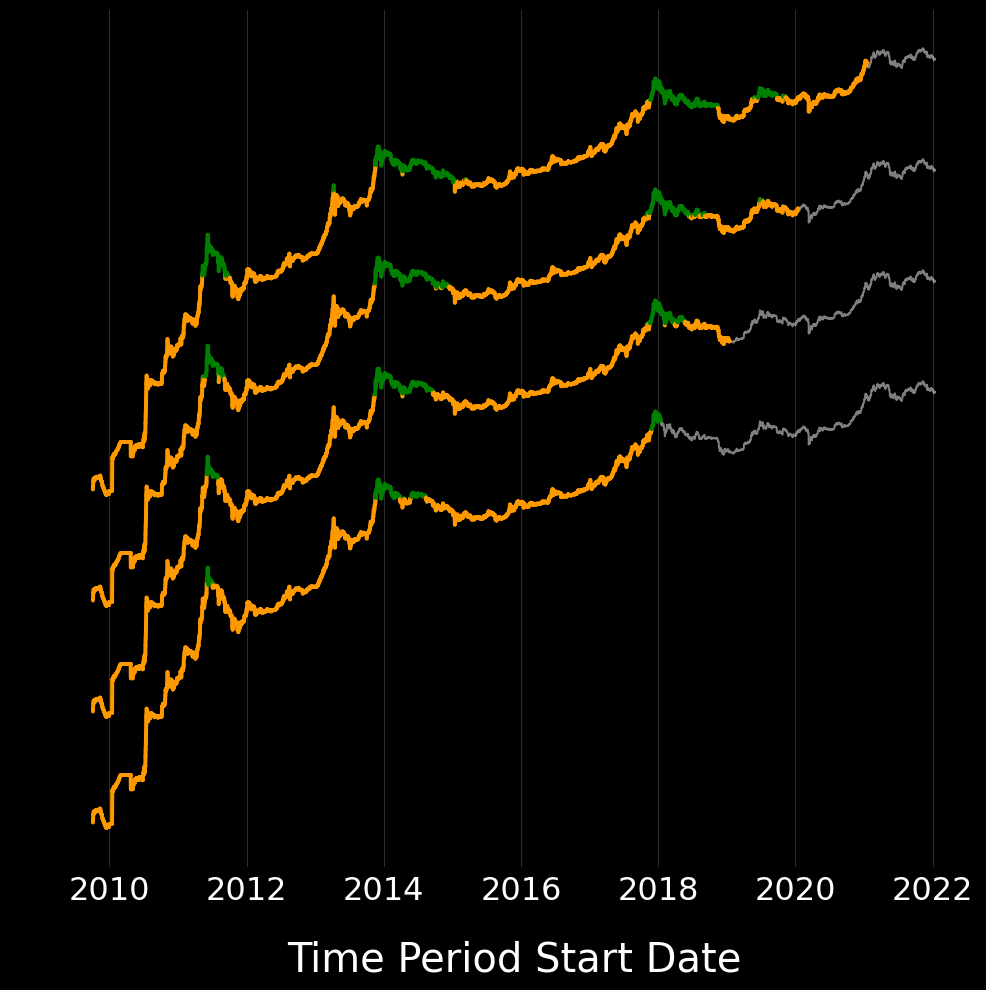

In [308]:
# Second figure depicting the best strategy for each analyzed time period

start_date = list(orig_dates).index('10/5/09')
end_date = list(orig_dates).index('1/14/22')
analysis_start_date = list(orig_dates).index('10/5/09')
plot_dca_interval = 1
plot_num_days_list = [1461, 1096, 730, 365]
analysis_end_date_list = [list(orig_dates).index('1/15/18'),
                          list(orig_dates).index('1/15/19'),
                          list(orig_dates).index('1/15/20'),
                          list(orig_dates).index('1/15/21')]
sep_n = 2.
res = (1000, 1000)
size = res[0]/96.
size_y = res[1]/96.

fig, (ax) = plt.subplots(1, 1, figsize=(size, size_y), dpi=96, facecolor='black')
ax.set_facecolor("black")
plt.rc('axes', axisbelow=True)

for n in range(len(plot_num_days_list)):
    plot_num_days = plot_num_days_list[n]
    analysis_end_date = analysis_end_date_list[n]
    for d in range(analysis_end_date-analysis_start_date):
        sb_return = sb_strategy_df[
            (sb_strategy_df['dca_interval'] == plot_dca_interval) &
            (sb_strategy_df['num_days'] == plot_num_days) &
            (sb_strategy_df['start_date_ind'] == analysis_start_date+d) &
            (sb_strategy_df['sb_percentage'] == 100)]['final_usd_return'].iloc[0]
        dca_return = sb_strategy_df[
            (sb_strategy_df['dca_interval'] == plot_dca_interval) &
            (sb_strategy_df['num_days'] == plot_num_days) &
            (sb_strategy_df['start_date_ind'] == analysis_start_date+d) &
            (sb_strategy_df['sb_percentage'] == 0)]['final_usd_return'].iloc[0]
        if sb_return > dca_return:
            plt.plot([dates[analysis_start_date+d], dates[analysis_start_date+d+1]],
                     [orig_prices[analysis_start_date+d]*10**(n*sep_n),
                      orig_prices[analysis_start_date+d+1]*10**(n*sep_n)],
                     color='#ff9900', lw=3, alpha=1, zorder=5, solid_capstyle='round')
        else:
            plt.plot([dates[analysis_start_date+d], dates[analysis_start_date+d+1]],
                     [orig_prices[analysis_start_date+d]*10**(n*sep_n),
                      orig_prices[analysis_start_date+d+1]*10**(n*sep_n)],
                     color='green', lw=3, alpha=1, zorder=5, solid_capstyle='round')
    plt.plot(dates[start_date:end_date+1],
             [p*10**(n*sep_n) for p in orig_prices[start_date:end_date+1]],
             color='w', alpha=0.5, solid_capstyle='round', zorder=4)
plt.xticks(fontsize=24, color='w')
plt.xlabel('Time Period Start Date', fontsize=30, color='w', labelpad=25)
xmin, xmax = min(dates[start_date:end_date+1]), max(dates[start_date:end_date+1])
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
plt.yscale('log')
x_axis_dates()
plt.xticks(rotation=0, horizontalalignment='center')
plt.grid(axis='x', alpha=0.25)
plt.tight_layout()

In [339]:
# # All time periods plotted in one figure (not used)

# res = (1920/1.5, 1920/2.)
# size = res[0]/96.
# size_y = res[1]/96.
# # create figure and axis objects with subplots()
# fig, ax = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
# ax.set_facecolor('black')
# plot_start_date_ind = 1824
# plot_dca_interval = 1
# plot_num_days_list = [365, 730, 1096, 1461]
# plot_num_days_label = ['1-Year', '2-Year', '3-Year', '4-Year']
# plot_median_label_rotation = [87.5, 82, 72, 51]
# plot_median_label_shift = [0.025, 0.025, 0.0275, 0.035]
# cmap = cm.get_cmap('rainbow', 100)
# plot_tf_color = [cmap(0), cmap(33), cmap(67), cmap(100)]
# plot_tf_alpha = [0.01, 0.0125, 0.0175, 0.02]
# ymin, ymax = -5, 105
# xmin, xmax = -100, 1700
# for p in range(len(plot_num_days_list)):
#     plot_num_days = plot_num_days_list[p]
#     plot_sb_percentages = range(101)
#     for d in range(plot_start_date_ind+plot_num_days):
#         temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
#                                  (sb_strategy_df['num_days'] == plot_num_days) &
#                                  (sb_strategy_df['start_date_ind'] == plot_start_date_ind+d)]
#         plt.plot(temp_df['final_usd_return'], temp_df['sb_percentage'], color=plot_tf_color[p],
#                  alpha=plot_tf_alpha[p], zorder=3)
#     sb_medians = []
#     for plot_sb_percentage in plot_sb_percentages:
#         temp_df = sb_strategy_df[(sb_strategy_df['dca_interval'] == plot_dca_interval) &
#                                  (sb_strategy_df['num_days'] == plot_num_days) &
#                                  (sb_strategy_df['start_date_ind'] >= plot_start_date_ind) &
#                                  (sb_strategy_df['sb_percentage'] == plot_sb_percentage)]
#         sb_median = temp_df['final_usd_return'].median()
#         if plot_sb_percentage == 50:
#             plt.text(sb_median-(xmax-xmin)*plot_median_label_shift[p], plot_sb_percentage,
#                      '%s Median Return' % plot_num_days_label[p],
#                      rotation=plot_median_label_rotation[p],
#                      fontsize=20, color='w', horizontalalignment='center',
#                      verticalalignment='center', zorder=5)
#         sb_medians.append(sb_median)
#     plt.plot(sb_medians, plot_sb_percentages, color=plot_tf_color[p], lw=3,
#              solid_capstyle='round', zorder=4)
# ax.grid(True, color='w', alpha=0.2)
# ax.set_ylim(ymin, ymax)
# plt.xlim(xmin, xmax)
# plt.yticks(color='w', fontsize=20)
# plt.xticks(color='w', fontsize=20)
# plt.text(xmax + (xmax - xmin)*0.0125, 0, '100', color='w', fontsize=20,
#          horizontalalignment='left', verticalalignment='center')
# plt.text(xmax + (xmax - xmin)*0.0125, 20, '80', color='w', fontsize=20,
#          horizontalalignment='left', verticalalignment='center')
# plt.text(xmax + (xmax - xmin)*0.0125, 40, '60', color='w', fontsize=20,
#          horizontalalignment='left', verticalalignment='center')
# plt.text(xmax + (xmax - xmin)*0.0125, 60, '40', color='w', fontsize=20,
#          horizontalalignment='left', verticalalignment='center')
# plt.text(xmax + (xmax - xmin)*0.0125, 80, '20', color='w', fontsize=20,
#          horizontalalignment='left', verticalalignment='center')
# plt.text(xmax + (xmax - xmin)*0.0125, 100, '0', color='w', fontsize=20,
#          horizontalalignment='left', verticalalignment='center')
# plt.text(xmin - (xmax - xmin)*0.075, 50, 'Smash Buy (%)', color='w', fontsize=26,
#          horizontalalignment='right', verticalalignment='center', rotation=90)
# plt.text(xmax + (xmax - xmin)*0.075, 50, 'Daily DCA (%)', color='w', fontsize=26,
#          horizontalalignment='left', verticalalignment='center', rotation=90)
# ax.set_xlabel('USD Return (%)', labelpad=20, color='w', fontsize=26)
# plt.text(xmin + (xmax - xmin)/2, ymax + (ymax - ymin)*0.1,
#          'Smash Buy vs DCA Analysis',
#          fontsize=34, color='w', horizontalalignment='center')
# plt.text(xmin + (xmax - xmin)/2, ymax + (ymax - ymin)*0.03,
#          'By Wicked Smart Bitcoin@w_s_bitcoin', fontsize=22, color='w',
#          horizontalalignment='center')
# plt.text(xmin - (xmax - xmin)*0.145, ymin - (ymax - ymin)*0.175, 'test', color='black',
#          horizontalalignment='left')
# plt.text(xmax + (xmax - xmin)*0.145, ymax + (ymax - ymin)*0.175, 'test', color='black',
#          horizontalalignment='right')
# plt.tight_layout()
# plt.show()